# WOfS-v2 System demo 

### Fei Zhang @Geoscience Australia 2016


##  Setting up environment import python modules etc

In [1]:
##  Setting up environment: python modules etc

# make my current source code python modules available in this notebook
import sys

paths=sys.path
#paths.append('/g/data1/u46/fxz547/Githubz/agdc-v2')
paths.insert(0,'/home/547/fxz547/myGithub/agdc-v2')  #prepend a path
paths.append('/home/547/fxz547/myGithub/wofs') #('/g/data1/u46/fxz547/Githubz/wofs')


In [2]:
from IPython.display import display
from pprint import pprint
from __future__ import print_function

import os
import glob
import numpy as np
import math
from pathlib import Path

from netCDF4 import Dataset, num2date, date2num
from collections import defaultdict
import xarray as xr
import xarray.ufuncs

import datacube
from datacube.api import GridWorkflow
from datacube.storage import  masking
from datacube.storage.storage import write_dataset_to_netcdf

from wofs.workflow.agdc_dao import AgdcDao
import wofs.workflow.make_water_tiles as mkwater

%matplotlib inline
import matplotlib.pyplot as plt
from pylab import rcParams
rcParams['figure.figsize'] = 10, 10 # increase plot size a bit...
rcParams['axes.formatter.useoffset'] = False  # disable scalar formatter / offset in axes labels

## Pixels classification on Landsat images

In [5]:
cellindex=(15,-40)

day1='2004-01-01'

day2='2004-12-31'

qdict = {'platform': ['LANDSAT_5'], 'time': (day1, day2)}

print (qdict)

dcdao = AgdcDao()

nbar_pq_data = dcdao.get_multi_nbarpq_tiledata(cellindex, qdict, maxtiles=10)  # maxtiles=100 for a year
#To be more specific, able to retrieve using eg, ((15, -40), numpy.datetime64('1992-09-16T09:12:23.500000000+1000'))

# todo: get DSM data for this cell
#dsm_data = dcdao.get_dsm_data(cellindex, {})

print("Number of (nbar,pqa) tile-pairs:", len(nbar_pq_data))

# Now ready to apply classification algorithm to the data tiles retrieved.

icounter = 0

for (celltime_key, nbar_tile, pq_tile) in nbar_pq_data:
    print (celltime_key)
    cellindex_tup = celltime_key[0]
    acq_dt = celltime_key[1]
    dtstamp = str(acq_dt)[:19].replace(':', '-')
    platform = 'LS5'  # can get from the nbar tile data

    water_classified_img = mkwater.produce_water_tile(nbar_tile, pq_tile) #, dsm_data[cellindex_tup])

    path2_waterfile = mkwater.define_water_fname(platform, cellindex_tup, dtstamp, nbar_tile)

    write_dataset_to_netcdf(water_classified_img,
                            global_attributes={},
                            variable_params={'waterextent': {'zlib': True}},
                            filename=Path(path2_waterfile))

    icounter += 1


{'platform': ['LANDSAT_5'], 'time': ('2004-01-01', '2004-12-31')}
Number of (nbar,pqa) tile-pairs: 10
((15, -40), numpy.datetime64('2004-01-05T10:29:03.000000000+1100'))
('no_data value=', -999)
('no data pixels: ', <xarray.DataArray ()>
array(5999618))
(1, 4000, 4000)
(4000, 4000)
('Pixel Stats: ', 'water_pix,cloud_pix, cloudshadow_pix, noncontig_pix, nodata_pix,  nowater_pix')
('Pixel Stats: ', 61381, 787361, 52376, 235648, 5999618, 8863616)
('Total number of pixel should be 16M ', 16000000)
DescribeResult(nobs=16000000, minmax=(0, 128), mean=4.149676125, variance=250.98471586914442, skewness=4.491004124456325, kurtosis=21.386843759039547)
('DateTime of satellite observation: ', '2004-01-05T10-29-03')
/g/data1/u46/fxz547/wofs2/extents/abc15_-40/LS5_water_15_-40_2004-01-05T10-29-03.nc
((15, -40), numpy.datetime64('2004-01-05T10:29:27.000000000+1100'))
('no_data value=', -999)
('no data pixels: ', <xarray.DataArray ()>
array(7288150))
(1, 4000, 4000)
(4000, 4000)
('Pixel Stats: ', 'wat

In [4]:
# use !ls to run commands
# !rm  /g/data1/u46/fxz547/wofs2/extents/abc15_-40/LS5_water_15_-40_2004*.nc

# Visualise Water Tiles

In [6]:
#ROOT_DIR="/g/data/u46/users/fxz547/wofs2/extents/abc15_-40/clfs"
ROOT_DIR="/g/data/u46/users/fxz547/wofs2/extents/abc15_-40"
ncfiles=glob.glob(ROOT_DIR+'/LS5_water*.nc')

#print(sorted(ncfiles)) 

In [7]:

def showimg(path2ncfile, band4view='waterextent'):

    f = Dataset(path2ncfile, 'r')

    # The NC data variable name?
    # band4view='waterextent'
    #bandarray = f[band4view][:, :]  #for water tiles 2D array. this will load all data into RAM.
    
    # for summary, there may be a time dimension, 3D array
    # 3D 
    bandarray = f[band4view][:, :, :]  

    fig = plt.figure()

    #im = plt.imshow(bandarray[time,:,:], cmap=plt.get_cmap('viridis'), animated=True)
    #im = plt.imshow(bandarray[:,:],  vmin=0, vmax=128) 
    #3D 
    im = plt.imshow(bandarray[0, :,:], vmin=0, vmax=128 ) #, cmap=plt.get_cmap('viridis'))
    plt.colorbar(orientation='vertical', shrink=0.8, label='Water=128, No-Water=0, No-Data=1');
    
    return 

In [8]:
# Show a list of nc files

# Define the list of nc tiles to be displayed
path2nc=[os.path.join(ROOT_DIR, ncf) for ncf in sorted(ncfiles)]
icount=0

def show_im(icount):
    path2ncimage=path2nc[ icount]  #

    print('showing image number:',icount, path2ncimage)
    showimg(path2ncimage)

    icount=icount+1
    if (icount ==len(ncfiles)):
        icount =0
        print ("Finished, resetting iount=0")
    return icount

icount=1

showing image number: 5 /g/data/u46/users/fxz547/wofs2/extents/abc15_-40/LS5_water_15_-40_1990-07-09T09-10-50.nc
Next will be  6


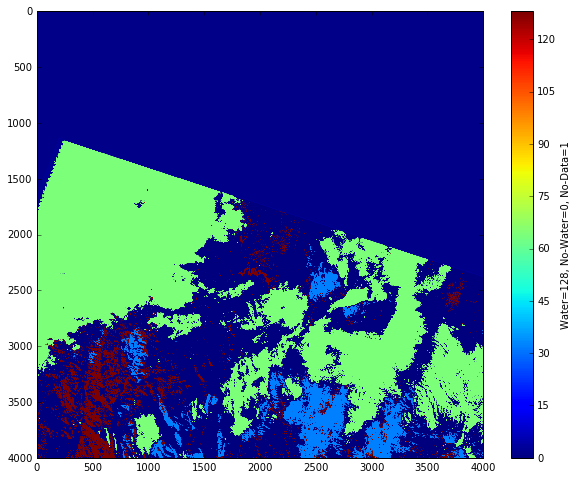

In [13]:
# execute this cell (ctr+enter) repeatedly until all done

icount = show_im(icount)
print("Next will be ", icount)

##  Water-Summary amd Visualization

In [ ]:
%pwd

In [14]:
run /g/data1/u46/users/fxz547/Githubz/wofs/wofs/workflow/make_watersummary.py /g/data/u46/users/fxz547/wofs2/extents/abc15_-40 nc 15_-40

13092054.0
956757669.0
done writing /g/data/u46/users/fxz547/wofs2/summaries/water_summary_15_-40.nc


In [15]:
!ls -l /g/data/u46/users/fxz547/wofs2/summaries/water_summary_15_-40.nc

-rw-rw-r--+ 1 fxz547 u46 8029336 Aug 17 15:15 /g/data/u46/users/fxz547/wofs2/summaries/water_summary_15_-40.nc


In [16]:
def show_water_summary(path2ncfile):
    
    f = Dataset(path2ncfile, 'r')
    
    # for summary, there may be a time dimension, 3D array
    waterdata= 'waterobs'
    cleardata='clearobs'
    
    warray = f[waterdata][:,:, :]  # this will load all data into RAM - may use up memory, spit out error
    carray = f[cleardata][:,:, :]
   


    #im = plt.imshow(bandarray[time,:,:], cmap=plt.get_cmap('viridis'), animated=True)
    # 2D-tiles im = plt.imshow(bandarray[:,:] ) 
#     im = plt.imshow(bandarray[0,:,:] ) #, cmap=plt.get_cmap('viridis'))
#     plt.colorbar(orientation='vertical', shrink=0.8, label='Water=128, No-Water=0, No-Data=1');

#     plt.figure( figsize=(16,13) )
#     plt.subplot( 1,3,1 )
    plt.imshow(warray[0,:,:] ) #, vmin=0, vmax=100)
    plt.title("Water Observations"); plt.xlabel('easting'); plt.ylabel('northing')
    plt.colorbar(orientation='vertical', shrink=0.8, label='Water Obs Counts');

    
#     plt.subplot( 1,3,2 )
#     #plt.imshow(subs_array)   # plotting the subset data directly
#     plt.imshow(carray[0,:,:], vmin=0, vmax=100, )
#     plt.title("Clear Observations"); plt.xlabel('easting'); plt.ylabel('northing')
#     plt.colorbar(orientation='vertical', shrink=0.3, label='obs counts');


#      plt.subplot( 1,3,3 )
#      plt.imshow(subs_array)   # plotting the subset data directly
#     plt.imshow(warray[0,:,:]/carray[0,:,:]) #, vmin=0, vmax=1, )
#     plt.title("Water/Clear Observations"); plt.xlabel('Easting Grid'); plt.ylabel('Northing Grid')
#     plt.colorbar(orientation='vertical', shrink=0.8, label='Percentage of Water Observations');

    return

In [17]:
# LS-5 watertiles summary

water_sum_file='/g/data/u46/users/fxz547/wofs2/summaries/water_summary_15_-40.nc' 


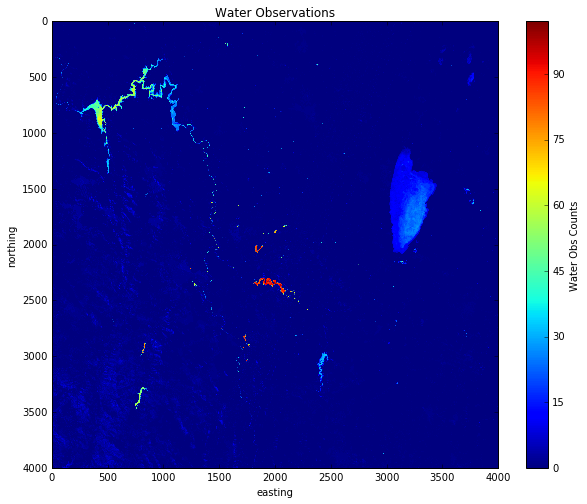

In [18]:
show_water_summary(water_sum_file)

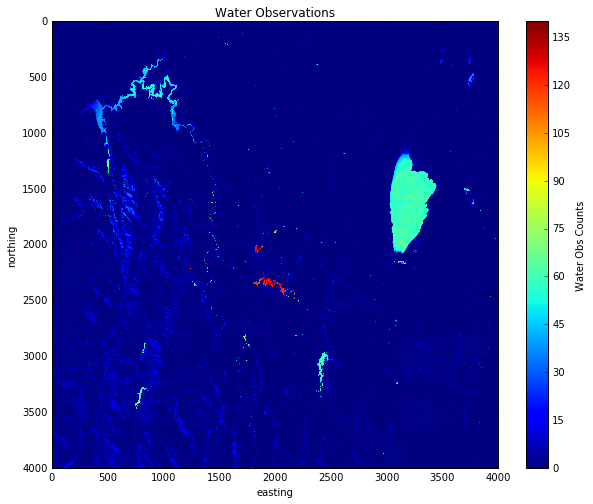

In [19]:
# Previous version: 7-year LS-5 water tiles summary

watersummary ="/g/data/u46/users/fxz547/wofs2/extents_unification1/summaries/water_summary_15_-40.nc"

show_water_summary(watersummary)